In [9]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from eurostat import get_data_df
from plotly.offline import init_notebook_mode, iplot
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


In [10]:
df = get_data_df('demo_gind')
df.head()

,freq,indic_de,geo\TIME_PERIOD,1960,1961,1962,1963,1964,1965,1966,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,A,AVG,AD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,72419.0,NaN,75486.0,76860.0,NaN,NaN,80562.0,83345.0,NaN
1,A,AVG,AL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,...,2880694.0,2876092.0,2873458.0,2866376.0,2854191.0,2837848.0,2811667.0,2777689.0,NaN,NaN
2,A,AVG,AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3004588.0,2992364.0,2979442.0,2969001.0,2962482.0,2961473.0,NaN,NaN,2984166.0,NaN
3,A,AVG,AT,7047539.0,7086299.0,7129864.0,7175811.0,7223801.0,7270889.0,7322066.0,...,8642699.0,8736668.0,8797566.0,8840521.0,8879920.0,8916864.0,8955797.0,9041851.0,9131761.0,NaN
4,A,AVG,AZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9649341.0,9757812.0,9854033.0,9939771.0,10024283.0,10093121.0,10137750.0,10141756.0,10153958.0,NaN


In [11]:
df = df.rename(columns={'geo\\TIME_PERIOD': 'geo'})

df_melted = df.melt(
  id_vars=['freq', 'indic_de', 'geo'],
  var_name='year',
  value_name='value'
)

df_melted['year'] = pd.to_numeric(df_melted['year'], errors='coerce')

Zadanie 1

Wykorzystując dowolny zbiór danych ze zbioru EUROSTAT, wyświetl jedną z cech numerycznych w postaci wykresu z mapą z przykładu w tym labie. Musisz dokonać mapowania nazw krajów, gdyż w parametrach wykresu oraz danych EUROSTAT te sktóry się trochę różnią. Link do pliku, który to ułatwi jest w komentarzu w kodzie przykładu wykresu z mapą.

In [12]:
init_notebook_mode(connected = True)

df_filtered = df_melted[
    (df_melted['year'] == 2021) &
    (df_melted['indic_de'] == 'MIGT')
    ].dropna(subset=['value'])

data = dict(
    type='choropleth',
    locations=['NLD', 'FIN', 'LVA', 'POL', 'FRA', 'BEL'],
    locationmode='ISO-3',
    z=df_filtered['value'],
    text=df_filtered['geo'],
    colorscale='Greens',
    colorbar={'title': 'MIGT Index'}
)

layout = dict(
    title='Wskaźnik MIGT w Europie (2021)',
    geo={'scope': 'europe'}
)

choromap = go.Figure(data=[data], layout=layout)
iplot(choromap)

Zadanie 2

Wykorzystując zbiór wine z biblioteki sklearn (load_wine(), podobnie jak ze zbiore iris) dokonaj analizy PCA tak aby:

zachować minimum 99% wariancji

zachować minimum 95% wariancji

zachować minimum 90% wariancji

Ile cech pozostało w tych zbiorach?

In [17]:
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1

print(f'Liczba cech dla >= 90% wariancji: {n_components_90}')
print(f'Liczba cech dla >= 95% wariancji: {n_components_95}')
print(f'Liczba cech dla >= 99% wariancji: {n_components_99}')

Liczba cech dla >= 90% wariancji: 8
Liczba cech dla >= 95% wariancji: 10
Liczba cech dla >= 99% wariancji: 12


In [21]:
for n, label in zip([n_components_90, n_components_95, n_components_99], ['90%', '95%', '99%']):
    W = pca.components_[:n]
    feature_importance = np.sum(np.abs(W), axis=0)
    sorted_indices = np.argsort(feature_importance)[::-1]
    top_indices = sorted_indices[:n]
    top_features = [feature_names[i] for i in top_indices]

    print(f"\nDla {label} wariancji (zachowano {n} komponent):")
    print(top_features)


Dla 90% wariancji (zachowano 8 komponent):
['proanthocyanins', 'nonflavanoid_phenols', 'magnesium', 'malic_acid', 'hue', 'alcalinity_of_ash', 'alcohol', 'ash']

Dla 95% wariancji (zachowano 10 komponent):
['nonflavanoid_phenols', 'proanthocyanins', 'hue', 'malic_acid', 'magnesium', 'alcohol', 'proline', 'ash', 'total_phenols', 'alcalinity_of_ash']

Dla 99% wariancji (zachowano 12 komponent):
['alcohol', 'proanthocyanins', 'hue', 'nonflavanoid_phenols', 'proline', 'malic_acid', 'od280/od315_of_diluted_wines', 'total_phenols', 'ash', 'magnesium', 'alcalinity_of_ash', 'color_intensity']


Zadanie 3

Wykorzystując przykład w labie wygeneruj wykres korelacji wartości cech wględem klasy decyzyjnej (target). Czy cechy, które PCA odrzuciło faktycznie były wskazane jako najlepsi kandydaci pod względem separowalności liniowej?

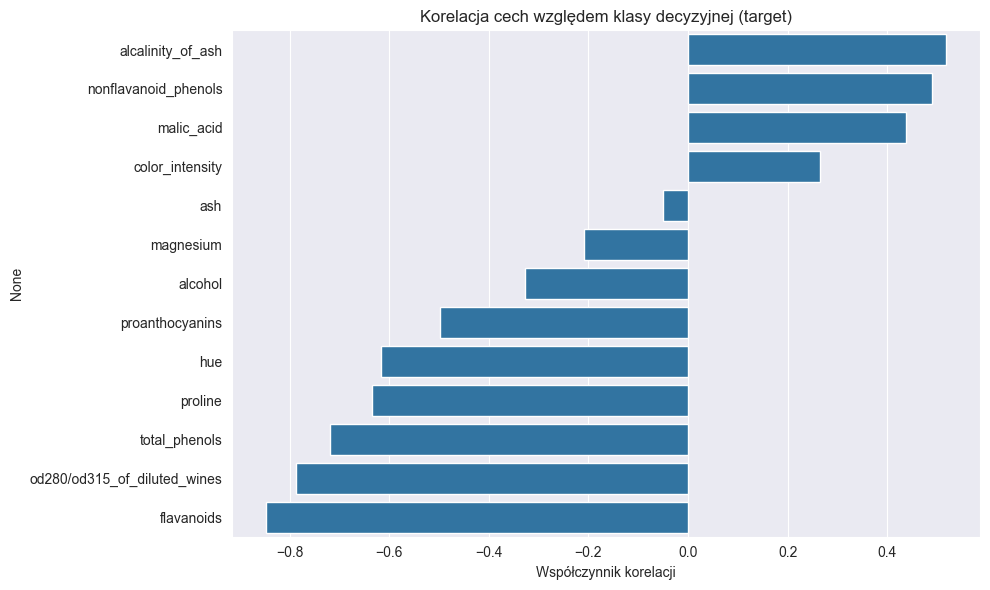

In [14]:
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name='target')

df_w = pd.concat([X, y], axis=1)

correlations = df_w.corr(numeric_only=True)['target'].drop('target').sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.title('Korelacja cech względem klasy decyzyjnej (target)')
plt.xlabel('Współczynnik korelacji')
plt.tight_layout()
plt.show()

Zadanie 4

Wykorzystując przykład w skrypcie z wykładu numer 11 (https://github.com/agazbrzezny/MAD_SWPS_2025/blob/master/wyklad_10/redukcja_wielowym.ipynb) pokazujący użycie SelectFromModel (punkt 4 wykładu) wykonaj tę samą sekwencję czynności z użyciem klasyfikatora RandomForest do selekcji cech. Po przetrenowaniu modelu drzewa stwórz 3 zbiory cech z progiem jak w zadaniu 2 sumując feature importance. Czy zostały wybrane te same cechy co w zadaniu 2?

In [22]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)

importances = rf.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

def select_features_by_importance(importances_sorted, threshold):
    cumsum = np.cumsum(importances_sorted)
    n_features = np.argmax(cumsum >= threshold) + 1
    return n_features

thresholds = [0.90, 0.95, 0.99]
selected_features_dict = {}

for t in thresholds:
    n_feats = select_features_by_importance(sorted_importances, t)
    selected_feats = sorted_features[:n_feats]
    selected_features_dict[t] = selected_feats
    print(f'\nDla {int(t*100)}% sumy ważności wybrano {n_feats} cech:')
    print(selected_feats)

#Odp: zostały wybrane inne ceche


Dla 90% sumy ważności wybrano 8 cech:
['flavanoids', 'color_intensity', 'alcohol', 'proline', 'od280/od315_of_diluted_wines', 'hue', 'total_phenols', 'malic_acid']

Dla 95% sumy ważności wybrano 10 cech:
['flavanoids', 'color_intensity', 'alcohol', 'proline', 'od280/od315_of_diluted_wines', 'hue', 'total_phenols', 'malic_acid', 'alcalinity_of_ash', 'magnesium']

Dla 99% sumy ważności wybrano 12 cech:
['flavanoids', 'color_intensity', 'alcohol', 'proline', 'od280/od315_of_diluted_wines', 'hue', 'total_phenols', 'malic_acid', 'alcalinity_of_ash', 'magnesium', 'proanthocyanins', 'ash']
